# Вебинар 4. Рекоммендательные системы с ранжирующим лоссом. Поиск похожих товаров и пользователей

---

### 1. Общие

ALS
- На вход принимает только *позитивные* взаимодействия
- Прогнозирует **не** вероятность, а некоторые числа
- В ALS нельзя добавить внешние фичи
- ALS не учитывает сезонность / зависимость во времени (но это можно частично поправить - см далее)
- Можно использовать для ранжирования (как - см далее + вебинар 5)

### 2. Что на самом деле оптимизирует ALS

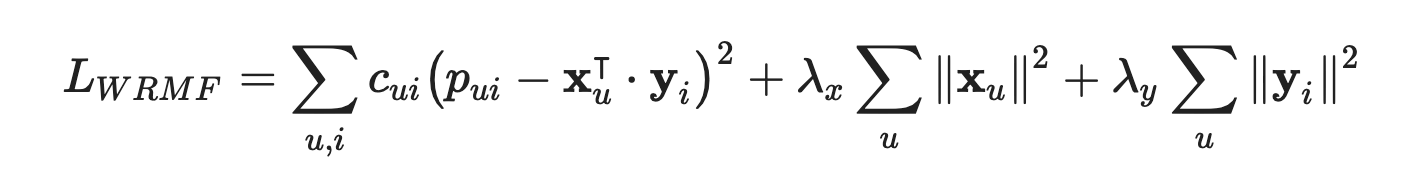

$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Что делает ALS**
- Максимизирует скалярное произведение (dot product) между векторами user-item для позитивных interactions, минимизирует для негативных

**Скалярное призведение (dot product) VS косинусная схожесть (cosine similarity)**

$$dot(a, b) = a * b$$  
  
$$cos(a, b) = \frac{a * b}{||a||*||b||} = \frac{dot(a, b)}{||a||*||b||}$$

### 3. Как учитывать изменение вкусов потребителей во времени / изменение популярности товара во времени

- Летом юзеры любят мороженое, а зимой - нет
- Многие фильмы популярны во время проката в кино, затем их популярность снижается

*Что делать?*  
Ограничить давность взаимодейстий.  
Давать последним взаимодействиям больший вес:  

$$value_w = \sum_i value_i * \frac{1}{1 + \exp^{ \alpha*t}}$$

### 4. Как использовать для ранжирования (Краткое введение. Подробности - на следующем вебинаре)

**Вариант 1.**  
*As is* - ранжировать по output ALS

**Вариант 2.**
*Та же модель, другой лосс - BPR*

BPR - Bayesian Personalized Ranking loss
1. Случайная пара user - купленный им item_i = позитивная пара
2. Для того же юзера сэмплируем item_j (не купил или вес в user-item матрице ниже, у item_i из 1.) - негативная пара
3. Прогнозы модели $p_{ui}$, $p_{uj}$ --> $p_{ui} - p_{uj}$
4. loss = $\sigma(p_{ui} - p_{uj})$ - это и есть наша ошибка
5. Обновляем эмбеддинги

In [1]:
from implicit.bpr import BayesianPersonalizedRanking

Синтаксис такой же как у AlternatingLeastSquares. ML модель такая же, лосс - BPR

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys
    


In [3]:
data = pd.read_csv('../data/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
item_features = pd.read_csv('../data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [5]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [6]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [7]:
# Заведем фиктивный item_id (если юзер покупал товары не из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [70]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    if len(recommended_list)==0:
        return 0
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(recommended_list, bought_list)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

In [11]:
tf_idf_user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [40]:
%%time

model = AlternatingLeastSquares(factors=20, 
                                regularization=0.02,
                                iterations=10, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(tf_idf_user_item_matrix,  # На вход item-user matrix
          show_progress=True)

/home/alexxl/Documents/GeekBrains/RecSys/venv2/lib/python3.9/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.013963699340820312 seconds
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 7.3 s, sys: 8.04 s, total: 15.3 s
Wall time: 1.25 s


In [41]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],  # !!! 
                                    recalculate_user=False)[0]]
    return res

In [42]:
%%time
    
result['tf_idf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['tf_idf'], row['actual']), axis=1).mean()

CPU times: user 2.08 s, sys: 4.97 s, total: 7.05 s
Wall time: 612 ms


0.18109696376101858

In [15]:
def ap_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    flags = np.isin(recommended_list,bought_list)
    
    if sum(flags) == 0:
        return 0
    
    sum_ = 0
    for i in range(k):
        
        if flags[i]:
            p_k = precision_at_k(recommended_list, bought_list, k=i+1)
            sum_ += p_k
            
    result = sum_ / k
    
    return result

In [16]:
%%time
    
result['tf_idf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: ap_at_k(row['tf_idf'], row['actual']), axis=1).mean()

CPU times: user 1.52 s, sys: 3.11 s, total: 4.63 s
Wall time: 487 ms


0.11786157362063338

### Важно не забыть сделать сортировку в результатах

In [17]:
%%time

model = ItemItemRecommender(10, 
                                num_threads=4)

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: user 1.04 s, sys: 3.74 ms, total: 1.04 s
Wall time: 288 ms


In [18]:
%%time
    
result['itemitem'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: ap_at_k(row['itemitem'], row['actual']), axis=1).mean()

CPU times: user 336 ms, sys: 854 µs, total: 337 ms
Wall time: 339 ms


0.1168788769180542

In [19]:
def get_sorted_recommendations(user, model, N=5):
    recs= model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],  # !!! 
                                    recalculate_user=False)
    mask = recs[1].argsort()[::-1]
    res = [id_to_itemid[rec] for rec in 
                    recs[0][mask]]
    return res

In [20]:
get_sorted_recommendations(10, model=model, N=5)

[1082185, 6534178, 1029743, 995242, 981760]

In [21]:
get_recommendations(10, model=model, N=5)

[981760, 1029743, 995242, 6534178, 1082185]

In [22]:
%%time
    
result['itemitem'] = result['user_id'].apply(lambda x: get_sorted_recommendations(x, model=model, N=5))
result.apply(lambda row: ap_at_k(row['itemitem'], row['actual']), axis=1).mean()

CPU times: user 358 ms, sys: 0 ns, total: 358 ms
Wall time: 357 ms


0.1541429970617042

In [23]:
%%time

model = BayesianPersonalizedRanking(factors=20, 
                                regularization=0.02,
                                iterations=10, 
                                num_threads=4)

model.fit(tf_idf_user_item_matrix,  # На вход item-user matrix
          show_progress=True)

/home/alexxl/Documents/GeekBrains/RecSys/venv2/lib/python3.9/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.013329029083251953 seconds
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 2.13 s, sys: 0 ns, total: 2.13 s
Wall time: 633 ms


In [24]:
def get_recommendations_bpr(user, model, N=5):
    res = [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=csr_matrix(user_item_matrix).tocsr()[userid_to_id[user]],   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],  # !!! 
                                    )[0]]
    return res

In [25]:
%%time
    
result['bpr'] = result['user_id'].apply(lambda x: get_recommendations_bpr(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['bpr'], row['actual']), axis=1).mean()

CPU times: user 16min, sys: 27min 19s, total: 43min 19s
Wall time: 6min 41s


0.13457394711067583

In [27]:
result.apply(lambda row: ap_at_k(row['bpr'], row['actual']), axis=1).mean()

0.1104162585700294

In [28]:
result.apply(lambda row: ap_at_k(row['tf_idf'], row['actual']), axis=1).mean()

0.11786157362063338

In [26]:
result.head(2)

,user_id,actual,tf_idf,itemitem,bpr
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[862349, 1005186, 1058997, 1082185, 1051211]","[1082185, 6534178, 1029743, 995242, 981760]","[1082185, 981760, 1127831, 826249, 1098066]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[951590, 5569230, 910032, 883404, 8090537]","[1082185, 6534178, 1029743, 995242, 981760]","[1082185, 981760, 826249, 1098066, 1127831]"


----

# Альтернативные способы предсказаний

### Кейс 1. Продажи товаров собственной торговой марки (СТМ)

У многих ритейлеров есть товары СТМ:
    - Азбука Вкуса - Просто Азбука
    - Ашан - Каждый день
    - ВкусВилл - ВкусВилл
    - ...
    
Как правило, у них маржинальность (~прибыль) > обычные товары.   
Как сделать так, чтобы юзеры переключились на товары СТМ? - *рекоммендации!*

*Нужно заменить те товары, которые пользователь уже покупает, на товары СТМ*

In [46]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
2820,202291,69,MISC SALES TRAN,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,
3565,397896,69,KIOSK-GAS,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,


In [47]:
item_features = item_features[item_features['item_id'].isin(itemid_to_id.keys())]
item_features[item_features['brand'] == 'Private'].item_id.nunique()

1464

In [48]:
own_items = item_features[item_features['brand'] == 'Private'].\
    groupby('department')['item_id'].nunique().\
    sort_values(ascending=False)
own_items

department
GROCERY            1229
MEAT-PCKGD           74
PRODUCE              32
PASTRY               31
DELI                 25
MISC SALES TRAN      20
DRUG GM              14
KIOSK-GAS            13
SEAFOOD-PCKGD        12
MEAT                  8
NUTRITION             5
FLORAL                1
Name: item_id, dtype: int64

In [49]:
categories_with_own_items = own_items.index.tolist()

In [50]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42, n_iter=300, n_iter_without_progress=20)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [51]:
model.item_factors.shape

(5001, 20)

In [52]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

/home/alexxl/Documents/GeekBrains/RecSys/venv2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


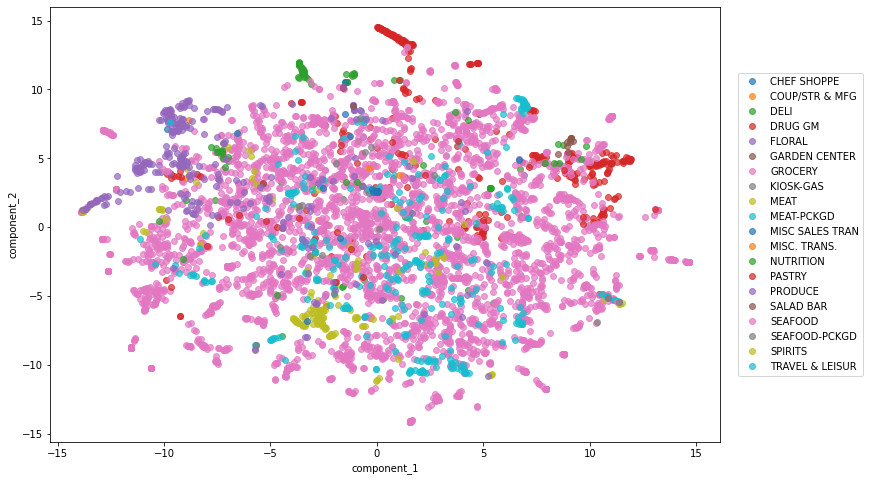

CPU times: user 1min 16s, sys: 3.94 s, total: 1min 20s
Wall time: 6.18 s


In [53]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne')
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne['item_id'] = list(itemid_to_id.keys())
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

In [54]:
item_emb_tsne_reduced = item_emb_tsne[item_emb_tsne['category'] != 'GROCERY']

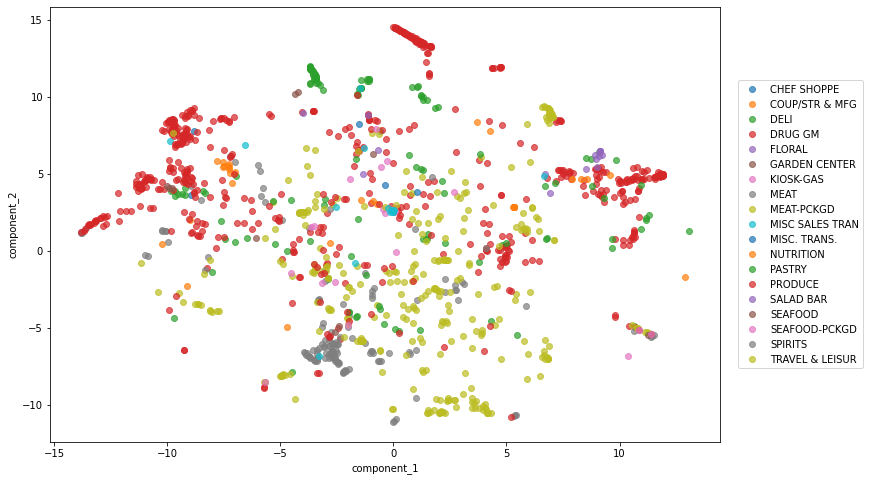

In [55]:
display_components_in_2D_space(item_emb_tsne_reduced, labels='category')

Нарисуем все товары в катгеориях, где есть СТМ

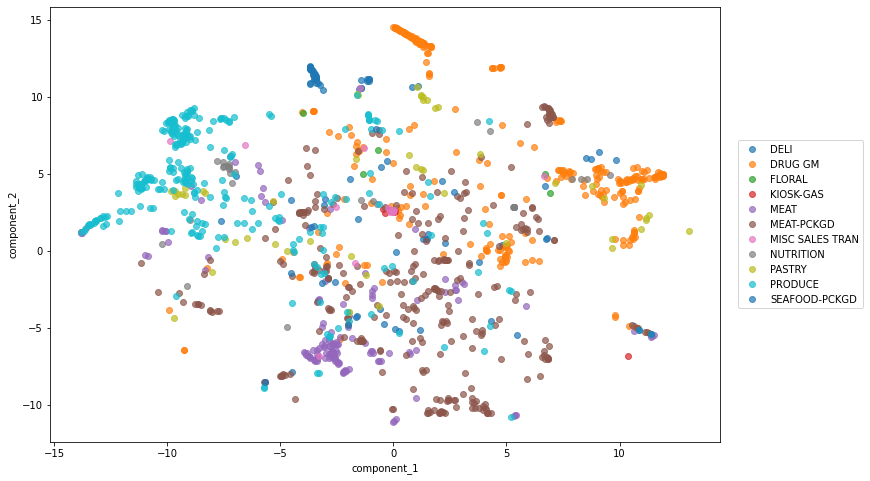

In [56]:
display_components_in_2D_space(item_emb_tsne_reduced[item_emb_tsne_reduced['category'].isin(categories_with_own_items)], 
                               labels='category')

In [57]:
similar_items = model.similar_items(itemid_to_id[1004906], N=50)
similar_items = [id_to_itemid[sim[0]] for sim in similar_items]
similar_items.append(1004906)

In [58]:
item_emb_tsne[item_emb_tsne['item_id'] == 1004906]

,component_1,component_2,category,item_id
2434,-13.687511,1.306158,PRODUCE,1004906


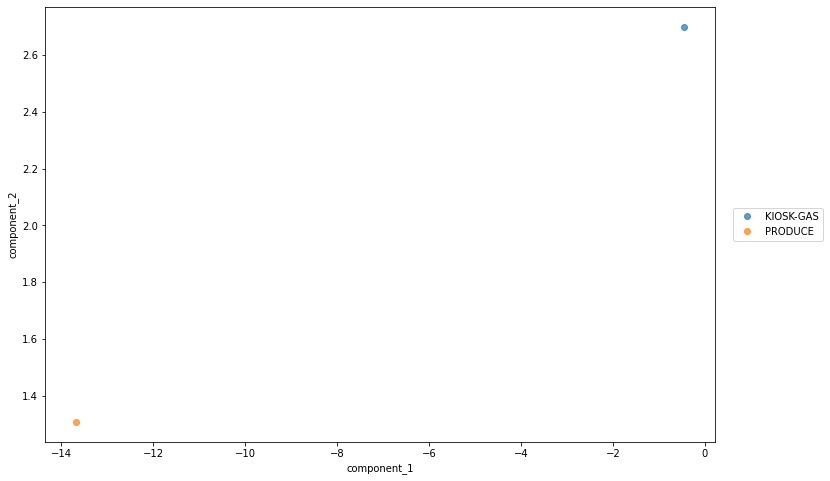

In [59]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['item_id'].isin(similar_items)], 
                               labels='category')

Берем топ-5 популярных покупок юзера --> находим по 1 наиболее близкому товару СТМ для них --> рекомендуем

In [60]:
# your_code

popularity = data_train.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
popularity.sort_values('quantity', ascending=False, inplace=True)

popularity = popularity[popularity['item_id'] != 999999]

popularity = popularity.groupby('user_id').head(5)

popularity.sort_values('user_id', ascending=False, inplace=True)
popularity.head(2)

,user_id,item_id,quantity
666913,2500,1058997,9
666919,2500,1065538,10


In [62]:
%%time

def get_rec(model, x):
    recs = model.similar_items(itemid_to_id[x], N=2)
    top_rec = recs[0][0]
    return id_to_itemid[top_rec]
    

popularity['similar_recommendation'] = popularity['item_id'].apply(lambda x: get_rec(model, x))
popularity.head(3)

CPU times: user 5.37 s, sys: 13.9 s, total: 19.2 s
Wall time: 1.37 s


,user_id,item_id,quantity,similar_recommendation
666913,2500,1058997,9,1058997
666919,2500,1065538,10,1065538
667027,2500,6534178,12,6534178


In [63]:
recommendation_similar_items = popularity.groupby('user_id')['similar_recommendation'].unique().reset_index()
recommendation_similar_items.columns=['user_id', 'similar_recommendation']
recommendation_similar_items.head(2)

,user_id,similar_recommendation
0,1,"[9527290, 1082185, 995242, 940947, 856942]"
1,2,"[916122, 8090521, 5569230, 1106523, 1133018]"


In [64]:
result = result.merge(recommendation_similar_items, on='user_id', how='left')
result.head(2)

,user_id,actual,tf_idf,itemitem,bpr,similar_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[862349, 1082185, 1051211, 965766, 981760]","[1082185, 6534178, 1029743, 995242, 981760]","[1082185, 981760, 1127831, 826249, 1098066]","[9527290, 1082185, 995242, 940947, 856942]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[951590, 5569230, 908531, 910032, 1029743]","[1082185, 6534178, 1029743, 995242, 981760]","[1082185, 981760, 826249, 1098066, 1127831]","[1092026, 951590, 998206, 1053690, 1106523]"


In [74]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    try:
        recommended_list = recommended_list[:k]
        
    except:
        return 0
    flags = np.isin(recommended_list, bought_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision



In [79]:
result.apply(lambda row: 1 if isinstance(row['similar_recommendation'],float) else len(row['similar_recommendation']), axis=1).mean()

4.97796278158668

In [42]:
%load_ext autoreload

In [43]:
# %autoreload
# from src.metrics import precision_at_k

# result.apply(lambda row: precision_at_k(row['similar_recommendation'], row['actual']), axis=1).mean()

### Кейс 2. Вашим друзьям нравится / Похожим пользователям нравится / ...

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [44]:
userid_to_id[10]

9

In [80]:
model.similar_users(userid_to_id[10], N=6)

(array([   9, 1552, 1681,  326,  354, 1050], dtype=int32),
 array([1.        , 0.90611   , 0.8911238 , 0.8734561 , 0.86423826,
        0.8627236 ], dtype=float32))

In [81]:
%%time

own = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

own.fit(csr_matrix(user_item_matrix).tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

  0%|          | 0/2499 [00:00<?, ?it/s]

CPU times: user 892 ms, sys: 94.4 ms, total: 987 ms
Wall time: 542 ms


In [ ]:
get_recommendations(user=1, model=own, N=1)

In [48]:
# your_code

-----

# Production

In [49]:
def prefilter_items(data):
    # Уберем самые популярные товары (их и так купят)
    popularity = data.groupby('item_id')['user_id'].nunique().reset_index() / data['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    
    # Уберем не интересные для рекоммендаций категории (department)
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    
    # Уберем слишком дорогие товарыs
    
    # ...
    
def postfilter_items(user_id, recommednations):
    pass

In [50]:
def get_recommendations(user, model, sparse_user_item, N=5):
    """Рекомендуем топ-N товаров"""
    
    res = [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],  # !!! 
                                    recalculate_user=True)[0]]
    return res

In [51]:
def get_similar_items_recommendation(user, model, N=5):
    """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
    
    # your_code
    
    return res

In [52]:
def get_similar_users_recommendation(user, model, N=5):
    """Рекомендуем топ-N товаров, среди купленных похожими юзерами"""
    
    # your_code
    
    return res

----